# FA24-CS634853 Data Mining Final Project Binary Classification

<b> Name: Adonis Pujols
<b> ap2933
<br> Date: 11/24/24
<br> Course: CS634 Data Mining
<br> Dataset Link: https://archive.ics.uci.edu/dataset/379/website+phishing
<br> Github Link: https://github.com/adonispujols-njit/cs634-final-project

# Outline

1. Discussion:
<br>1.a Introduction
<br>1.b Setup
<br>1.c Analysis/Conclusion (final results at bottom)
Code/Charts:
2. Preprocessing:
<br> 2.a Loading Data
<br> 2.b Dataset Analysis
<br> 2.c Normalization
3. Model Training:
<br> 3.a Random Forests
<br> 3.b SVM
<br> 3.c KNN
<br> 3.d Conv1D
5. Results (analysis is above):

# 1. Discussion

# 1.a Introduction
<br> This project implements the required and optional algorithms for the binary classification of website phising. The dataset consists of over a thousand websites divided into legitimate, phishing, and suspicious. The features consists of whether it has a popup window, the age of the domain, the url length, etc.

# 1.b Setup

#### <b>Requirements</b>
Packages:
<br> * refer to requirements.txt


#### <b>Install</b>
Conda setup steps: You may skip if you already have a compatible conda enviroment running. But make sure to install the requirements as noted below
<br><b>conda init # unless conda is already running
<br>conda create -n cs634 python # create enviroment, but any existing python3 enviroment will do
<br>conda activate cs634


Extract pujols_adonis_finalproj.zip using any tool of your choice. Assuming you already have conda/pip installed, run the following command to install all required packages:
<br><b>pip install -r requirements.txt

# 1.c Analysis/Conclusion (final results at bottom)

Surprisingly, SVM was the highest performing model compared to all of them, with RandomForest scoring the lowest. However all models including KNN and Conv1D were able to achieve both 97%+ accuracy and a F1 Score >= 0.97. Conv1D was second best at precision, however. The slight gap between SVM and the neural network could be explained by the necessary padding done to the data. As I was running this on my local machine, I forced a matrix size for torch that would be optimized to my hardware. This involved slight padding with null values that may have reduced the accuracy somewhat for the benefit of speed. The high coorelation between the labels and attributes atttributed to the sucess of all of these models. Moving forward, one should apply this technique on a dataset with more over a hundred or a thousand features to see the true benefits gained from the Conv1D neural network.

# 2. Preprocessing:

# 2.a Loading Data

In [62]:
from scipy import stats
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import (
    train_test_split,
    StratifiedShuffleSplit,
    GridSearchCV
)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchinfo import summary
import warnings


# useful functions for later
class KFoldCrossValidateInTorch:
    def __init__(
        self,
        model_class,
        loss_fn,
        learning_rate,
        epochs,
        batch_size,
        cv: StratifiedShuffleSplit,
        device,
    ) -> None:
        self.model_class = model_class
        self.loss_fn = loss_fn
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.cv = cv
        self.device = device
        self.models = []

    def training_loop(self, train_loader, model, optimizer):
        model.train()
        for X_batch, y_batch in train_loader:
            pred = model(X_batch)
            loss = self.loss_fn(pred, y_batch)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        model.eval()
        with torch.no_grad():
            pred = model(train_loader.dataset.tensors[0])
            y_train = train_loader.dataset.tensors[1]

            matrix = confusion_matrix( torch.argmax(y_train, dim=1).cpu().numpy(), torch.argmax(pred, dim=1).cpu().numpy())
            TP = matrix[0][0]
            FP = matrix[1][0]
            FN = matrix[0][1]
            P = TP + FN
            recall = TP / P
            precision = TP / (TP + FP)
            f1_score = 2 * (precision * recall) / (precision + recall)

    def val_nn_model(self, val_dataset: TensorDataset, model):
        model.eval()
        with torch.no_grad():
            X_val, y_val = val_dataset.tensors
            pred = model(X_val)
            loss = self.loss_fn(pred, y_val)

            matrix = confusion_matrix( torch.argmax(y_val, dim=1).cpu().numpy(), torch.argmax(pred, dim=1).cpu().numpy())
            TP = matrix[0][0]
            FP = matrix[1][0]
            FN = matrix[0][1]
            P = TP + FN
            recall = TP / P
            precision = TP / (TP + FP)
            f1_score = 2 * (precision * recall) / (precision + recall)
            
            return loss, pred, f1_score

    def fit(self, X, y):
        val_cv = {}
        for cv_step, (train_index, val_index) in enumerate(self.cv.split(X, y)):
            best_f1_score = -1
            print(f"Cross validation step {cv_step+1}\n")

            model = self.model_class()
            optimizer = torch.optim.Adamax(model.parameters(), lr=self.learning_rate)
            lr_scheduler = torch.optim.lr_scheduler.StepLR(
                optimizer, step_size=5, gamma=0.45
            )

            X_train = torch.tensor(
                X[train_index], dtype=torch.float32
            ) 
            y_train = torch.tensor(
                y[train_index], dtype=torch.float32
            ) 

            X_val = torch.tensor(X[val_index], dtype=torch.float32)
            y_val = torch.tensor(y[val_index], dtype=torch.float32)

            train_dataset = TensorDataset(X_train, y_train)
            train_loader = DataLoader(
                train_dataset, batch_size=self.batch_size, shuffle=True
            )
            val_dataset = TensorDataset(X_val, y_val)

            for epoch in range(self.epochs):
                print(f"Epoch {epoch + 1}\n-------------------------------")
                self.training_loop(train_loader, model, optimizer)
                lr_scheduler.step()

                _, _, val_f1_score = self.val_nn_model(val_dataset, model)
                
                print(f"Epoch {epoch + 1} completed\n")

            _, y_pred, _ = self.val_nn_model(val_dataset, model)
            val_cv[cv_step + 1] = print_data_matrix(
                y_val.argmax(dim=1), y_pred.argmax(dim=1)
            )
            val_cv[cv_step + 1]["Brier Score"] = (
                torch.mean((y_pred[:, 1] - y_val.argmax(dim=1)) ** 2).cpu().numpy()
            )
            val_cv[cv_step + 1]["Brier Skill Score"] = (
                (
                    val_cv[cv_step + 1]["Brier Score"]
                    / (
                        torch.mean(
                            (y_val.argmax(dim=1) - torch.mean(y_pred[:, 1])) ** 2
                        )
                    )
                )
                .cpu()
                .numpy()
            )
            self.models.append(model)

        val_cv["mean"] = pd.DataFrame(val_cv).mean(axis=1)
        return pd.DataFrame(val_cv).round(4)


    def predict(self, X):
        preds = []
        for cv_model in self.models:
            cv_model.eval()
            with torch.no_grad():
                preds.append(cv_model(X).cpu())
        preds = np.array(preds)
        return np.mean(preds, axis=0)
        
def print_data_matrix(y_test, y_pred):
    matrix = confusion_matrix(y_test, y_pred)
    FN = matrix[0][1]
    TP = matrix[0][0]
    FP = matrix[1][0]
    TN = matrix[1][1]
    P = TP + FN
    N = TN + FP
    TPR = TP / P
    TNR = TN / N
    FPR = FP / N
    FNR = FN / P
    recall = TPR
    precision = TP / (TP + FP)
    f1_score = 2 * (precision * recall) / (precision + recall)
    error_rate = (FP + FN) / (P + N)
    accuracy = (TP + TN) / (P + N)
    heidke_skill_score = (TP) / (TP + FN) - (FP) / (FP + TN)
    true_skill_statistics = TPR - FPR
    
    balanced_accuracy = (TPR + TNR) / 2
    
    return {
        "TP": TP,
        "TN": TN,
        "FP": FP,
        "FN": FN,
        "P": P,
        "N": N,
        "TPR": TPR,
        "TNR": TNR,
        "FPR": FPR,
        "FNR": FNR,
        "Recall": recall,
        "Precision": precision,
        "F1 Score": f1_score,
        "Accuracy": accuracy,
        "Error Rate": error_rate,
        "Accuracy (balanced)": balanced_accuracy,
        "(True) Skill Difference": true_skill_statistics,
        "Heidke Skill Score": heidke_skill_score,
    }


In [63]:
df = pd.read_csv('./data/PhishingData.csv')
df.head()

,sfh,popupwidnow,sslfinal_state,request_url,url_of_anchor,web_traffic,url_length,age_of_domain,having_ip_address,result
0,1,-1,1,-1,-1,1,1,1,0,0
1,-1,-1,-1,-1,-1,0,1,1,1,1
2,1,-1,0,0,-1,0,-1,1,0,1
3,1,0,1,-1,-1,0,1,1,0,0
4,-1,-1,1,-1,0,0,-1,1,0,1


# 2.b Dataset Analysis

Verify there are no null values (dataset also reported this but it is important to verify)

In [64]:
df.isna().any()

sfh                  False
popupwidnow          False
sslfinal_state       False
request_url          False
url_of_anchor        False
web_traffic          False
url_length           False
age_of_domain        False
having_ip_address    False
result               False
dtype: bool

## Feature Distribution

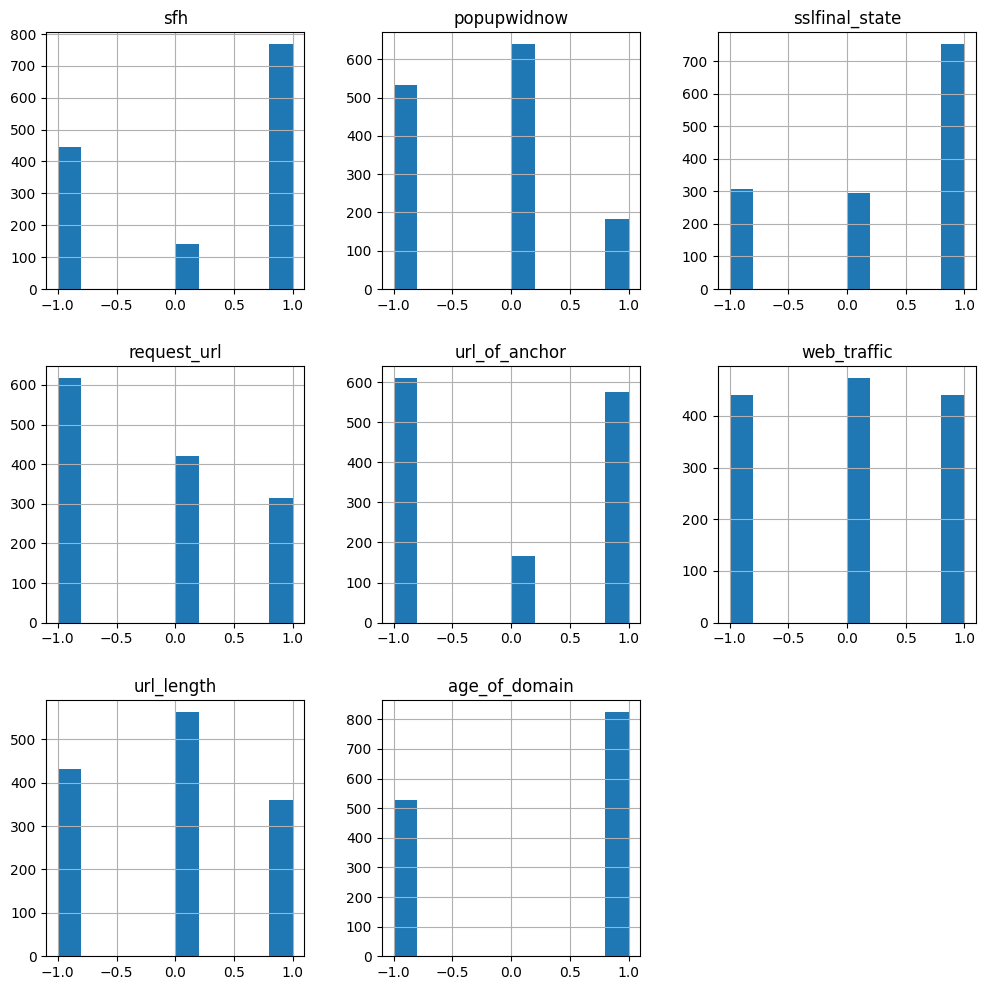

In [65]:
_ = df.iloc[:, :-2].hist(figsize=(12, 12))

## Correlations

The heatmap here for correlations confirms that there is high correlation between a few of our features. 

In [66]:
heatmap = pd.concat([df.iloc[:, :-1], pd.Series(df['result'].factorize()[0], name='result')], axis=1)
heatmap.corr().style.background_gradient(cmap='coolwarm')

,sfh,popupwidnow,sslfinal_state,request_url,url_of_anchor,web_traffic,url_length,age_of_domain,having_ip_address,result
sfh,1.000000,0.375943,0.368690,0.257247,0.333703,-0.187082,0.151503,0.163182,0.043349,0.565158
popupwidnow,0.375943,1.000000,0.218050,0.111520,0.167760,-0.140407,0.136229,0.076815,0.123399,0.401551
sslfinal_state,0.368690,0.218050,1.000000,0.057239,0.088525,-0.171719,0.095055,0.208091,0.108000,0.352899
request_url,0.257247,0.111520,0.057239,1.000000,0.337277,-0.045858,0.048431,0.053348,0.013346,0.339158
url_of_anchor,0.333703,0.167760,0.088525,0.337277,1.000000,-0.092045,0.097581,0.069178,0.039412,0.270117
web_traffic,-0.187082,-0.140407,-0.171719,-0.045858,-0.092045,1.000000,-0.108204,-0.683857,-0.094957,-0.145090
url_length,0.151503,0.136229,0.095055,0.048431,0.097581,-0.108204,1.000000,0.075338,0.165152,0.042791
age_of_domain,0.163182,0.076815,0.208091,0.053348,0.069178,-0.683857,0.075338,1.000000,0.040379,0.131346
having_ip_address,0.043349,0.123399,0.108000,0.013346,0.039412,-0.094957,0.165152,0.040379,1.000000,0.038130
result,0.565158,0.401551,0.352899,0.339158,0.270117,-0.145090,0.042791,0.131346,0.038130,1.000000


### Target Output Distribution

Note that -1 means confirmed phising, 0 means suspicious, and 1 means a legitimate website.

<Axes: xlabel='result'>

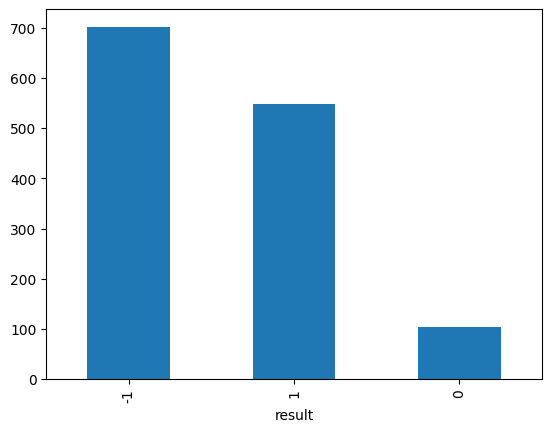

In [67]:
df['result'].value_counts().plot(kind='bar')

# 2.c Normalization

In [68]:
encoder = LabelEncoder()
df['Class_numerical'] = encoder.fit_transform(df['result'])

In [69]:
encoder.inverse_transform([0, 1])

array([-1,  0])

In [70]:
X_train, X_test, y_train, y_test = train_test_split(
    df.iloc[:, :-2],
    df["Class_numerical"],
    test_size=0.2,
    random_state=42,
    shuffle=True,
    stratify=df["Class_numerical"],
)

In [71]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(X_train)
X_train = pd.DataFrame(scaled_features, columns=df.columns[:-2])
X_test = pd.DataFrame(scaler.transform(X_test), columns=df.columns[:-2])
X_train.head()

,sfh,popupwidnow,sslfinal_state,request_url,url_of_anchor,web_traffic,url_length,age_of_domain,having_ip_address
0,-0.276630,-1.09032,-0.384314,0.281147,0.017646,-1.227590,0.060479,0.807408,-0.363042
1,-1.373016,-1.09032,-0.384314,-0.970711,-1.043057,1.257448,-1.248286,-1.238531,-0.363042
2,-1.373016,-1.09032,0.831557,-0.970711,-1.043057,0.014929,0.060479,0.807408,-0.363042
3,-1.373016,-1.09032,0.831557,-0.970711,-1.043057,1.257448,-1.248286,-1.238531,-0.363042
4,0.819757,-1.09032,0.831557,-0.970711,1.078348,1.257448,-1.248286,-1.238531,-0.363042


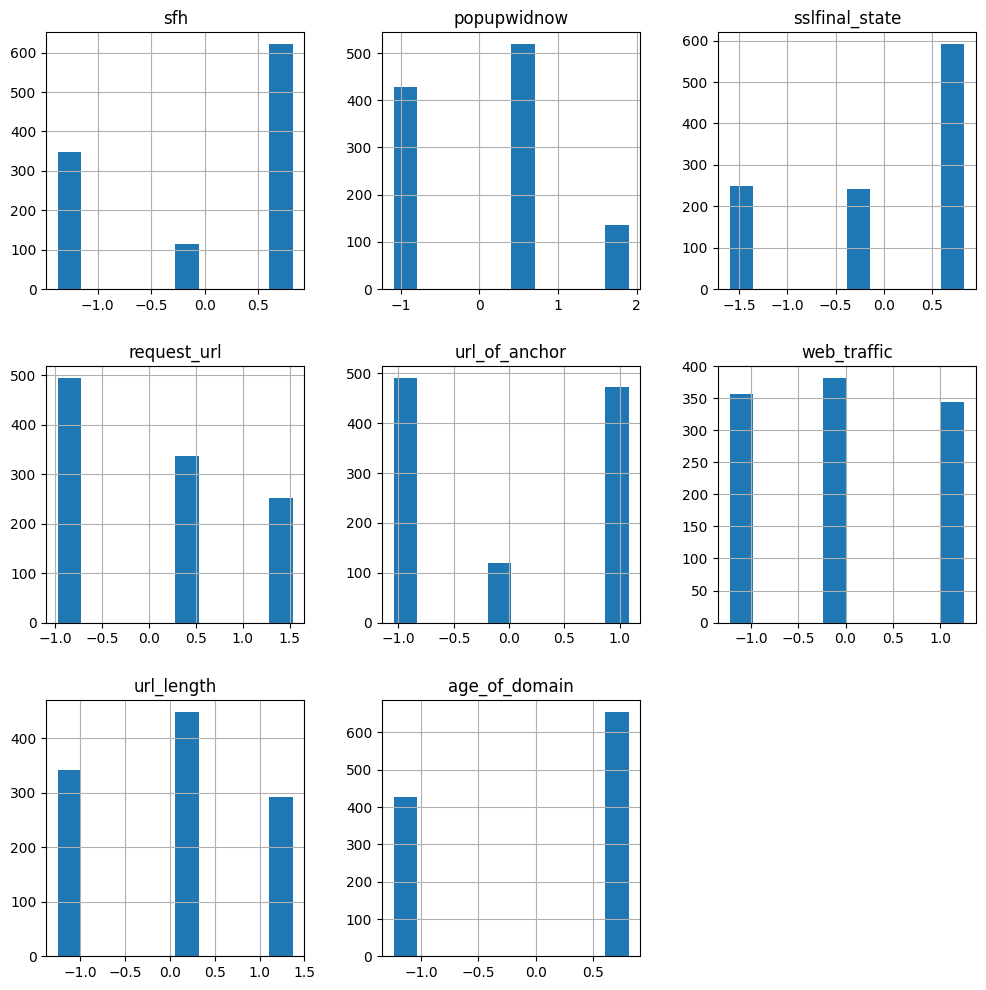

In [72]:
_ = X_train.iloc[:, :-1].hist(figsize=(12, 12))

# 3. Model Training:

In [73]:
matrix_results = pd.DataFrame({'RandomForest': {}, 'SVM': {}, 'KNN': {}, 'Conv1D': {}})

# 3.a Random Forests

In [74]:
stratified_split = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=42)

In [75]:
random_forest_cv = {}
random_forest_cv_models = []

for i, (train_index, test_index) in enumerate(stratified_split.split(X_train, y_train)):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
    random_forest = RandomForestClassifier(n_estimators=300, max_depth=12, ccp_alpha=5e-4, n_jobs=-1)
    random_forest.fit(X_train_fold, y_train_fold)
    
    y_pred = random_forest.predict(X_val_fold)
    y_pred_proba = random_forest.predict_proba(X_val_fold)[:, 1]
    random_forest_cv[i+1] = print_data_matrix(y_val_fold, y_pred)
    random_forest_cv[i+1]['Brier Score'] = np.mean((y_pred_proba - y_val_fold)**2)
    random_forest_cv[i+1]['Brier Skill Score'] = random_forest_cv[i+1]['Brier Score'] / (np.mean((y_val_fold - np.mean(y_pred_proba))**2))
    random_forest_cv_models.append(random_forest)

random_forest_cv['mean'] = pd.DataFrame(random_forest_cv).mean(axis=1)
pd.DataFrame(random_forest_cv).round(4)

,1,2,3,4,5,6,7,8,9,10,mean
TP,52.0000,53.0000,53.0000,52.0000,54.0000,52.0000,49.0000,54.0000,52.0000,52.0000,52.3000
TN,6.0000,7.0000,5.0000,6.0000,6.0000,7.0000,6.0000,4.0000,7.0000,7.0000,6.1000
FP,1.0000,0.0000,1.0000,0.0000,2.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.5000
FN,0.0000,1.0000,1.0000,1.0000,0.0000,0.0000,1.0000,1.0000,0.0000,1.0000,0.6000
P,52.0000,54.0000,54.0000,53.0000,54.0000,52.0000,50.0000,55.0000,52.0000,53.0000,52.9000
N,7.0000,7.0000,6.0000,6.0000,8.0000,7.0000,6.0000,4.0000,8.0000,7.0000,6.6000
TPR,1.0000,0.9815,0.9815,0.9811,1.0000,1.0000,0.9800,0.9818,1.0000,0.9811,0.9887
TNR,0.8571,1.0000,0.8333,1.0000,0.7500,1.0000,1.0000,1.0000,0.8750,1.0000,0.9315
FPR,0.1429,0.0000,0.1667,0.0000,0.2500,0.0000,0.0000,0.0000,0.1250,0.0000,0.0685
FNR,0.0000,0.0185,0.0185,0.0189,0.0000,0.0000,0.0200,0.0182,0.0000,0.0189,0.0113


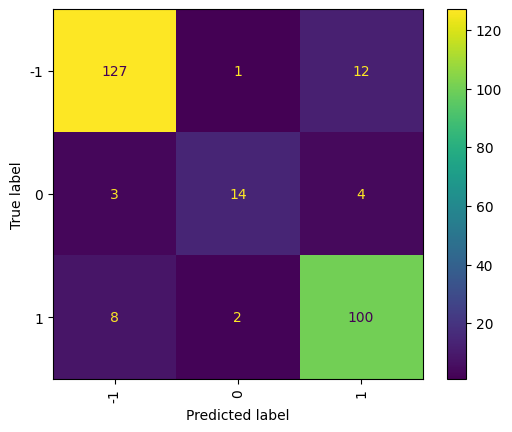

In [76]:
y_pred = stats.mode([model.predict(X_test) for model in random_forest_cv_models]).mode


matrix_results['RandomForest'] = print_data_matrix(y_test, y_pred)
matrix_results.loc["Brier Score", "RandomForest"] = np.mean((y_pred - y_test) ** 2)
matrix_results.loc["Brier Skill Score", "RandomForest"] = matrix_results["RandomForest"][
    "Brier Score"
] / (np.mean((y_test - np.mean(y_pred)) ** 2))

warnings.filterwarnings("ignore", message="The number of FixedLocator locations")
try:
    ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred,
        display_labels=[-1,0,1],
        xticks_rotation="vertical",
    )
    
    RocCurveDisplay.from_predictions(y_test, y_pred)
except ValueError:
    pass

# 3.b SVM

In [77]:
stratified_split = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=42)

In [78]:
svc_cv = {}
svc_cv_models = []

for i, (train_index, test_index) in enumerate(stratified_split.split(X_train, y_train)):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
    svc = SVC(C= 100, degree= 2, kernel= 'rbf', probability=True, random_state=42)
    svc.fit(X_train_fold, y_train_fold)
    
    y_pred = svc.predict(X_val_fold)
    y_pred_proba = svc.predict_proba(X_val_fold)[:, 1]
    svc_cv[i+1] = print_data_matrix(y_val_fold, y_pred)
    svc_cv[i+1]['Brier Score'] = np.mean((y_pred_proba - y_val_fold)**2)
    svc_cv[i+1]['Brier Skill Score'] = svc_cv[i+1]['Brier Score'] / (np.mean((y_val_fold - np.mean(y_pred_proba))**2))
    svc_cv_models.append(svc)

svc_cv['mean'] = pd.DataFrame(svc_cv).mean(axis=1)
pd.DataFrame(svc_cv).round(4)

,1,2,3,4,5,6,7,8,9,10,mean
TP,52.0000,52.0000,53.0000,52.0000,52.0000,50.0000,51.0000,53.0000,52.0000,50.0000,51.7000
TN,5.0000,7.0000,5.0000,5.0000,6.0000,7.0000,6.0000,5.0000,6.0000,6.0000,5.8000
FP,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,1.0000,0.6000
FN,0.0000,0.0000,1.0000,1.0000,1.0000,0.0000,1.0000,1.0000,0.0000,1.0000,0.6000
P,52.0000,52.0000,54.0000,53.0000,53.0000,50.0000,52.0000,54.0000,52.0000,51.0000,52.3000
N,6.0000,7.0000,6.0000,5.0000,7.0000,7.0000,7.0000,5.0000,7.0000,7.0000,6.4000
TPR,1.0000,1.0000,0.9815,0.9811,0.9811,1.0000,0.9808,0.9815,1.0000,0.9804,0.9886
TNR,0.8333,1.0000,0.8333,1.0000,0.8571,1.0000,0.8571,1.0000,0.8571,0.8571,0.9095
FPR,0.1667,0.0000,0.1667,0.0000,0.1429,0.0000,0.1429,0.0000,0.1429,0.1429,0.0905
FNR,0.0000,0.0000,0.0185,0.0189,0.0189,0.0000,0.0192,0.0185,0.0000,0.0196,0.0114


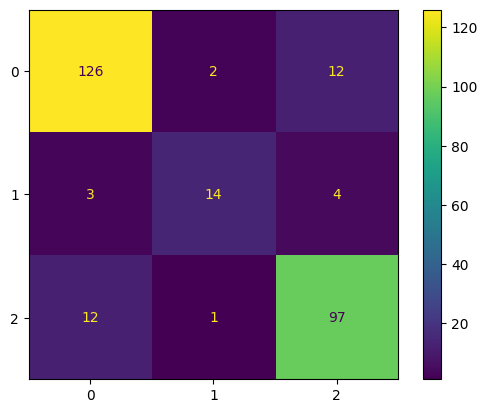

In [79]:
y_pred = stats.mode([model.predict(X_test) for model in svc_cv_models]).mode
matrix = confusion_matrix(y_test, y_pred)

matrix_results['SVM'] = print_data_matrix(y_test, y_pred)
matrix_results.loc["Brier Score", "SVM"] = np.mean((y_pred - y_test) ** 2)
matrix_results.loc["Brier Skill Score", "SVM"] = matrix_results["SVM"][
    "Brier Score"
] / (np.mean((y_test - np.mean(y_pred)) ** 2))

try:
    ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred,
        display_labels=encoder.inverse_transform([0, 1]),
        xticks_rotation="vertical",
    )
except ValueError:
    pass



# 3.c KNN

In [80]:
stratified_split = StratifiedShuffleSplit(n_splits=6, test_size=0.1, random_state=42)

In [81]:
knn_cv = {}
knn_cv_models = []

for i, (train_index, test_index) in enumerate(stratified_split.split(X_train, y_train)):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    knn = KNeighborsClassifier(
        algorithm="ball_tree",
        leaf_size=10,
        n_neighbors=5,
        p=2,
        weights="distance",
        n_jobs=-1,
    )
    knn.fit(X_train_fold, y_train_fold)

    y_pred = knn.predict(X_val_fold)
    y_pred_proba = knn.predict_proba(X_val_fold)[:, 1]
    knn_cv[i + 1] = print_data_matrix(y_val_fold, y_pred)
    knn_cv[i+1]['Brier Score'] = np.mean((y_pred_proba - y_val_fold)**2)
    knn_cv[i+1]['Brier Skill Score'] = knn_cv[i+1]['Brier Score'] / (np.mean((y_val_fold - np.mean(y_pred_proba))**2))
    knn_cv_models.append(knn)

knn_cv["mean"] = pd.DataFrame(knn_cv).mean(axis=1)
pd.DataFrame(knn_cv).round(4)

,1,2,3,4,5,6,mean
TP,51.0000,50.0000,51.0000,50.0000,51.0000,51.0000,50.6667
TN,4.0000,7.0000,7.0000,4.0000,4.0000,6.0000,5.3333
FP,2.0000,0.0000,0.0000,1.0000,2.0000,0.0000,0.8333
FN,0.0000,1.0000,2.0000,2.0000,0.0000,0.0000,0.8333
P,51.0000,51.0000,53.0000,52.0000,51.0000,51.0000,51.5000
N,6.0000,7.0000,7.0000,5.0000,6.0000,6.0000,6.1667
TPR,1.0000,0.9804,0.9623,0.9615,1.0000,1.0000,0.9840
TNR,0.6667,1.0000,1.0000,0.8000,0.6667,1.0000,0.8556
FPR,0.3333,0.0000,0.0000,0.2000,0.3333,0.0000,0.1444
FNR,0.0000,0.0196,0.0377,0.0385,0.0000,0.0000,0.0160


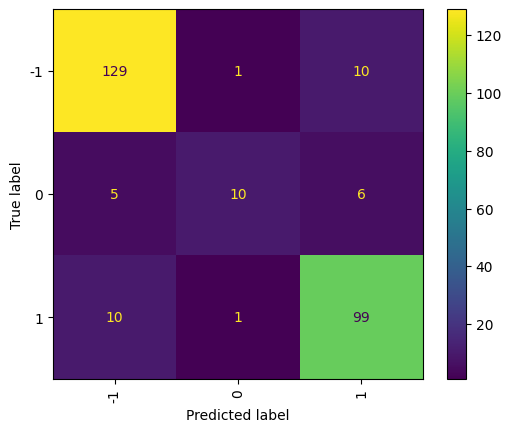

In [82]:
y_pred = stats.mode([model.predict(X_test) for model in knn_cv_models]).mode
matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=[-1,0,1],
    xticks_rotation="vertical",
)

matrix_results['KNN'] = print_data_matrix(y_test, y_pred)
matrix_results.loc["Brier Score", "KNN"] = np.mean((y_pred - y_test) ** 2)
matrix_results.loc["Brier Skill Score", "KNN"] = matrix_results["KNN"][
    "Brier Score"
] / (np.mean((y_test - np.mean(y_pred)) ** 2))

# 3.d Conv1D

In [83]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
print(f"Using {device} device for torch models")

Using cuda device for torch models


In [84]:
class Conv1DNNModel(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.conv1d_relu_stack = nn.Sequential(
           nn.Conv1d(in_channels=1, out_channels=128, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.BatchNorm1d(128),
                nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.BatchNorm1d(64),
                nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.BatchNorm1d(32),
                nn.Flatten(),
                nn.Linear(32 * 16, 64),
                nn.ReLU(),
                nn.BatchNorm1d(64),
                nn.Linear(64, 3),  # outputting 3 values, one for each class
                nn.Softmax(dim=1))  # Use Softmax for multi-class probabilities 

    def forward(self, x):
        return self.conv1d_relu_stack(x)

In [85]:
learning_rate = 1e-2
batch_size = 64
epochs = 20

conv1d_model = Conv1DNNModel()
loss_fn = nn.BCEWithLogitsLoss()
summary(conv1d_model, input_size=(batch_size, 1, 16))

Layer (type:depth-idx)                   Output Shape              Param #
Conv1DNNModel                            [64, 3]                   --
├─Sequential: 1-1                        [64, 3]                   --
│    └─Conv1d: 2-1                       [64, 128, 16]             512
│    └─ReLU: 2-2                         [64, 128, 16]             --
│    └─BatchNorm1d: 2-3                  [64, 128, 16]             256
│    └─Conv1d: 2-4                       [64, 64, 16]              24,640
│    └─ReLU: 2-5                         [64, 64, 16]              --
│    └─BatchNorm1d: 2-6                  [64, 64, 16]              128
│    └─Conv1d: 2-7                       [64, 32, 16]              6,176
│    └─ReLU: 2-8                         [64, 32, 16]              --
│    └─BatchNorm1d: 2-9                  [64, 32, 16]              64
│    └─Flatten: 2-10                     [64, 512]                 --
│    └─Linear: 2-11                      [64, 64]                  32,832
│

In [86]:
y_train_one_hot = pd.get_dummies(y_train.values, dtype=np.float32)
y_test_one_hot = pd.get_dummies(y_test.values, dtype=np.float32)

import numpy as np
import pandas as pd

desired_length = 16

# pad our data to fit in network
def pad_or_truncate(data, desired_length, is_X = False):
    padded_data = []

    # Convert to NumPy array if it's a DataFrame
    if isinstance(data, pd.DataFrame):
        data = data.values
    elif isinstance(data, pd.Series):
        data = data.values

    if is_X:
        for seq in data:
            if len(seq) < desired_length:
                padding_length = desired_length - len(seq)
                padded_seq = np.pad(seq, (0, padding_length), 'constant')  # Pad with zeros at the end
            else:
                padded_seq = seq[:desired_length]  # Truncate if longer
            padded_data.append(padded_seq)
    else:
        padded_data = data
    return np.array(padded_data)


# Apply padding/truncation to our features (X)
padded_X_train = pad_or_truncate(X_train, desired_length, is_X = True)
padded_X_test = pad_or_truncate(X_test, desired_length, is_X = True)


train_dataset = TensorDataset(
    torch.tensor(padded_X_train.reshape((-1, 1, desired_length)), dtype=torch.float32),
    torch.tensor(y_train.values, dtype=torch.float32),
)
test_dataset = TensorDataset(
    torch.tensor(padded_X_test.reshape((-1, 1, desired_length)), dtype=torch.float32),
    torch.tensor(y_test.values, dtype=torch.float32),
)




In [87]:
stratified_cv_split = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=42)

conv1d_cv = KFoldCrossValidateInTorch(
    model_class=Conv1DNNModel,
    loss_fn=loss_fn,
    learning_rate=learning_rate,
    batch_size=batch_size,
    epochs=epochs,
    cv=stratified_cv_split,
    device=device
)
conv1d_cv.fit(padded_X_train.reshape((-1, 1, desired_length)), y_train_one_hot.values)


Cross validation step 1

Epoch 1
-------------------------------
Epoch 1 completed

Epoch 2
-------------------------------
Epoch 2 completed

Epoch 3
-------------------------------
Epoch 3 completed

Epoch 4
-------------------------------
Epoch 4 completed

Epoch 5
-------------------------------
Epoch 5 completed

Epoch 6
-------------------------------
Epoch 6 completed

Epoch 7
-------------------------------
Epoch 7 completed

Epoch 8
-------------------------------
Epoch 8 completed

Epoch 9
-------------------------------
Epoch 9 completed

Epoch 10
-------------------------------
Epoch 10 completed

Epoch 11
-------------------------------
Epoch 11 completed

Epoch 12
-------------------------------
Epoch 12 completed

Epoch 13
-------------------------------
Epoch 13 completed

Epoch 14
-------------------------------
Epoch 14 completed

Epoch 15
-------------------------------
Epoch 15 completed

Epoch 16
-------------------------------
Epoch 16 completed

Epoch 17
--------

,1,2,3,4,5,6,7,8,9,10,mean
TP,54,53,52,51,54,55,47,49,52,53,52.0
TN,3,2,1,4,4,3,3,4,2,4,3.0
FP,3,2,3,1,2,3,2,2,4,0,2.2
FN,0,0,0,4,0,0,2,1,0,1,0.8
P,54,53,52,55,54,55,49,50,52,54,52.8
N,6,4,4,5,6,6,5,6,6,4,5.2
TPR,1.0,1.0,1.0,0.927273,1.0,1.0,0.959184,0.98,1.0,0.981481,0.984794
TNR,0.5,0.5,0.25,0.8,0.666667,0.5,0.6,0.666667,0.333333,1.0,0.581667
FPR,0.5,0.5,0.75,0.2,0.333333,0.5,0.4,0.333333,0.666667,0.0,0.418333
FNR,0.0,0.0,0.0,0.072727,0.0,0.0,0.040816,0.02,0.0,0.018519,0.015206


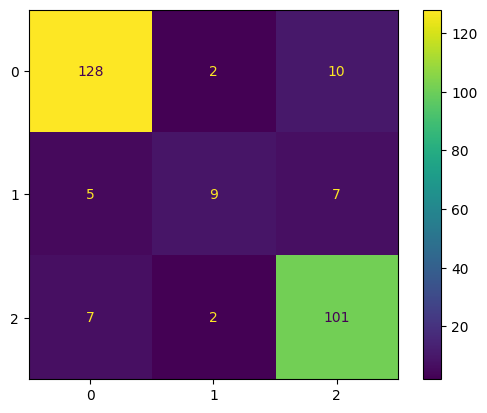

In [88]:
y_pred = conv1d_cv.predict(test_dataset.tensors[0]).argmax(axis=1)
matrix = confusion_matrix(y_test, y_pred)

matrix_results["Conv1D"] = print_data_matrix(y_test, y_pred)
matrix_results.loc["Brier Score", "Conv1D"] = np.mean((y_pred - y_test) ** 2)
matrix_results.loc["Brier Skill Score", "Conv1D"] = matrix_results["Conv1D"][
    "Brier Score"
] / (np.mean((y_test - np.mean(y_pred)) ** 2))

try:
    ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred,
        display_labels=encoder.inverse_transform([0, 1]),
        xticks_rotation="vertical",
    )
except ValueError:
    pass



# 5. Results (analysis is above):

In [89]:
# comparing all the models
matrix_results.round(4)

,RandomForest,SVM,KNN,Conv1D
TP,127.0000,126.0000,129.0000,128.0000
TN,14.0000,14.0000,10.0000,9.0000
FP,3.0000,3.0000,5.0000,5.0000
FN,1.0000,2.0000,1.0000,2.0000
P,128.0000,128.0000,130.0000,130.0000
N,17.0000,17.0000,15.0000,14.0000
TPR,0.9922,0.9844,0.9923,0.9846
TNR,0.8235,0.8235,0.6667,0.6429
FPR,0.1765,0.1765,0.3333,0.3571
FNR,0.0078,0.0156,0.0077,0.0154
